In [1]:
from helpers import *

In [2]:
%matplotlib inline

In [3]:
def get_pics(dicom_array):
    return map(lambda x: x.pixel_array, dicom_array)

def all_times(dirpath):
    pics = os.listdir(dirpath)
    times = []
    for path in sorted(pics):
        times.append(dicom.read_file(os.path.join(dirpath, path)))
    return times

def all_slices(case=1, pix=False):
    datadir = os.path.join(root_train, '%d/study/' % case)
    slices = []
    sizes = set()
    lengths = set()

    meta = (
        'PixelSpacing',
        'SliceThickness',
        # add field names we want
        'ImageOrientationPatient',
        'ImagePositionPatient'
    )
    meta_defaults = {
        'PixelSpacing': (1.5*1.5),
        'SliceThickness': 8.,
        # add defaults we want
        'ImageOrientationPatient': [1,0,0,0,1,0],
        'ImagePositionPatient':[0,0,0]
    }
    meta_funcs = {
        'PixelSpacing': lambda (h,w): (float(h),float(w)),
        'SliceThickness': float,
        # add lambdas
        'ImageOrientationPatient': lambda x: np.array(x),
        'ImagePositionPatient': lambda x: np.array(x)
    }

    def get_meta(sli):
        sli_meta = {}
        for att in meta:
            try:
                val = meta_funcs[att](getattr(sli[0], att))
            except Exception:
                val = meta_defaults[att]
                'Warning: Patient %d has a missing value for %s.' % (case, att)
                'Using default: %s' % str(val)
            sli_meta[att] = val
        return sli_meta

    for path in sorted(glob(os.path.join(datadir, 'sax_*')),
                       key=lambda x: int(x.split('sax_')[-1])):
        slices.append(all_times(path))
        lengths.add(len(slices[-1]))
        sizes = sizes.union(set([np.shape(t.pixel_array) for t in slices[-1]]))

    if len(sizes) > 1:
        print 'Warning: Patient %d has different sized images.' % case
        return None

    common_length = min(lengths)
    if len(lengths) > 1:
        print 'Warning: Patient %d has more than one series length.' % case
        print 'Using min length %d.' %  common_length

    new_slices = []
    prev = -500
    for sli in sorted(slices, key=lambda x: x[0].SliceLocation):
        cur = sli[0].SliceLocation
        sli = sli[:common_length]
        sli_meta = get_meta(sli)

        if pix:
            sli = get_pics(sli)

        sli = (sli, sli_meta)

        if cur - prev < 1:
            new_slices[-1] = sli
        else:
            new_slices.append(sli)

        prev = cur

    return zip(*new_slices)

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [18]:
import pandas
train_labels = pandas.read_csv(root_train+'.csv')
train_labels['EF'] = (train_labels.Diastole - train_labels.Systole)/train_labels.Diastole
train_labels = train_labels.set_index(train_labels.Id)
train_labels = train_labels.drop([41,83,148,195,222,260,280,305,337,393,437,442,456])

In [22]:
train_labels['Systole'].mean(), train_labels['Systole'].std()

(71.7279260780287, 43.11911629107116)

In [24]:
train_labels['Diastole'].mean(), train_labels['Diastole'].std()

(165.59260780287485, 59.36063239010576)

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### Load a patient, along with it's 2 and 4 chamber views

In [4]:
meta = (
    'PixelSpacing',
    'SliceThickness',
    'ImageOrientationPatient',
    'ImagePositionPatient'
)
meta_defaults = {
    'PixelSpacing': (1.5,1.5),
    'SliceThickness': 8.,
    'ImageOrientationPatient': [1,0,0,0,1,0],
    'ImagePositionPatient':[0,0,0]
}
meta_funcs = {
    'PixelSpacing': lambda (h,w): (float(h),float(w)),
    'SliceThickness': float,
    'ImageOrientationPatient': lambda x: np.array(x),
    'ImagePositionPatient': lambda x: np.array(x)
}
def get_meta(sli):
    sli_meta = {}
    for att in meta:
        val = meta_funcs[att](getattr(sli, att))
        sli_meta[att] = val
    return sli_meta

dirs1 = {} #2ch
dirs2 = {} #4ch
for case in range(1,501):
    datadir = os.path.join(root_train, '%d/study/' % case)
    #chamber = os.path.join(datadir)
    dirs1[case] = glob(os.path.join(datadir, '2ch_*'))[0]
    try:
        dirs2[case] = glob(os.path.join(datadir, '4ch_*'))[0]
    except:
        dirs2[case] = None

In [30]:
ch = all_times(dirs1[1])
pics = [c.pixel_array for c in ch]

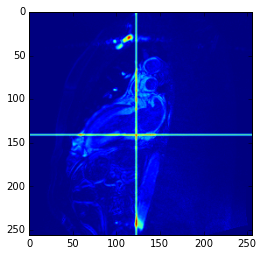

In [31]:
two_ch_stfd = spatial_temporal_finite_difference(pics)
row, col = get_centroid(two_ch_stfd)
center = line_mask(two_ch_stfd, row, col)
plt.imshow(center + two_ch_stfd)

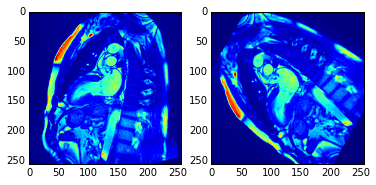

In [48]:
plt.subplot(1,2,1)
plt.imshow(pics[11])
plt.subplot(1,2,2)
plt.imshow(scipy.misc.imrotate(pics[11], 60))

In [411]:
for case in range(101,501):
    try:
        two_chamber = all_times(dirs1[case])   # 2 Chamber View
        two_ch = get_meta(two_chamber[0]) #Get at t=0
        two_ch_pic = two_chamber[0].pixel_array
        four_chamber = all_times(dirs2[case])[0]  # 4 Chamber View at t=0
        four_ch = get_meta(four_chamber)
        four_ch_pic = four_chamber.pixel_array
        # 4 chamber plane
        dir1 = four_ch['ImageOrientationPatient'][:3]
        dir2 = four_ch['ImageOrientationPatient'][3:]
        normal_4ch = np.cross(dir1, dir2)
        point_4ch = four_ch['ImagePositionPatient']
        b4 = normal_4ch[1]
        c4 = normal_4ch[2]
        d4 = np.dot(point_4ch, normal_4ch)
        #2ch Plane
        dir1 = two_ch['ImageOrientationPatient'][:3]
        dir2 = two_ch['ImageOrientationPatient'][3:]
        normal_2ch = np.cross(dir1, dir2)
        point_2ch = two_ch['ImagePositionPatient']
        b2 = normal_2ch[1]
        c2 = normal_2ch[2]
        d2 = np.dot(point_2ch, normal_2ch)
        fig = plt.figure(figsize=(9,9))
        plt.xlim(0, two_ch_pic.shape[1])
        plt.ylim(two_ch_pic.shape[0], 0)
        plt.imshow(two_ch_pic)
        # Get intersection in (x,y,z) coordinates
        intersection = intersect_planes(normal_4ch, normal_2ch, b4, b2, c4, c2, d4, d2)
        p1 = (intersection(-1000).T - point_2ch).T
        p2 = (intersection(1000).T - point_2ch).T
        two_points = np.concatenate((p1, p2), 1)
        # Transform intersection to 2 Chamber pixel coordinates
        pixel_sp = np.sqrt(two_ch['PixelSpacing'])
        lax_xyz_to_pix = (np.array(([dir2, dir1]))/pixel_sp)
        line_pixels = np.matmul(lax_xyz_to_pix, two_points).astype(int)
        # Plot that shit
        ys = np.linspace(line_pixels[0][0],line_pixels[0][1])
        xs = np.linspace(line_pixels[1][0],line_pixels[1][1])
        plt.plot(xs, ys, 'r')
        #plt.savefig(str(case))
        #plt.close(fig)
    except:
        print "Broken ", case

Broken  101
Broken  116
Broken  135
Broken  144
Broken  166
Broken  176
Broken  191
Broken  200
Broken  216
Broken  440
Broken  489


## ++++++++++++++++++++++++ Make a Patient Class ++++++++++++++++++++++++++++++

In [6]:
class Slice(object):
    '''A Slice Object contains multiple images ordered in time of a particular patient MRI Slice, along with
        metadata relevant to the slice'''
    def __init__(self, sli):
        m = (
            'PixelSpacing',
            'SliceThickness',
            'ImageOrientationPatient',
            'ImagePositionPatient'
        )
        m_defaults = {
            'PixelSpacing': (1.5,1.5),
            'SliceThickness': 8.,
            'ImageOrientationPatient': [1,0,0,0,1,0],
            'ImagePositionPatient':[0,0,0]
        }
        m_funcs = {
            'PixelSpacing': lambda (h,w): (float(h),float(w)),
            'SliceThickness': float,
            'ImageOrientationPatient': lambda x: np.array(x),
            'ImagePositionPatient': lambda x: np.array(x)
        }       
        self.meta = {}
        for att in m:
            try:
                self.meta[att] = m_funcs[att](getattr(sli[0], att))
            except AttributeError:
                self.meta[att] = m_defaults[att]
                print 'Warning: Patient %d has a missing value for %s.' % (case, att)
                print 'Using default: %s' % str(val)
        
        self.images = map(lambda x: x.pixel_array, sli)

In [ ]:
class Patient(object):
    '''Patient object contains all of a patients metadata and images'''
    def __init__(self, case):
        patient, meta = all_slices(case, pix=True)
        # get layer meta data
        pix_spacing = np.array([m['PixelSpacing'] for m in meta])
        heights = get_heights_from_meta(meta)
        num_layers, num_times = np.shape(patient)[0:2]


## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [4]:
def intersect_lines(m1,m2,c1,c2):
    x = (c2 - c1)/(m1 - m2)
    y = m1*x + c1
    return int(x),int(y)

In [5]:
def get_line_from_points(line_pixels, imshape):
    '''Gets equation of line and x_bounds to draw line. line_pixels is a 2x2 matrix where each column is a point
        on the line'''
    dy = line_pixels[0][0] - line_pixels[0][1]
    dx = line_pixels[1][0] - line_pixels[1][1]
    m = float(dy)/dx
    c = line_pixels[0][0] - m*line_pixels[1][0]
    x_left = max(0,-1*c/m)
    x_right = min(imshape[1], (imshape[0]-c)/m)
    if c < 0:
        if m > 0:
            x_left = max(0,-1*c/m)
            x_right = min(imshape[1], (imshape[0]-c)/m)
        else:
            print 'No Line'
            x_right = min(imshape[1],-1*c/m)
            x_left = max(0, (imshape[0]-c)/m)
    else:
        if m > 0:
            x_left = max(0,-1*c/m)
            x_right = min(imshape[1], (imshape[0]-c)/m)
        else:
            x_right = min(imshape[1], -1*c/m)
            x_left = max(0, (imshape[0]-c)/m)
        
    return m, c, int(x_left), int(x_right)
######################
def intersect_planes(n1,n2,d1,d2):
    normal = np.cross(n1, n2).reshape(3,1)
    A = np.array([[n1[1], n1[2]],[n2[1], n2[2]]])
    p = np.zeros((3,1))
    p[1:] = np.matmul(np.linalg.inv(A),np.array([[d1],[d2]]))
    
    return lambda x: x*normal + p
####################
def get_plane_equation(sli):
    '''Takes a slice at a particular time and returns its plane equation.
        Returns normal vector and scalar d which represents offset'''
    meta = get_meta(sli)
    pic = sli.pixel_array
    dir1 = meta['ImageOrientationPatient'][:3]
    dir2 = meta['ImageOrientationPatient'][3:]
    normal = np.cross(dir1, dir2)
    point = meta['ImagePositionPatient']
    sp_y, sp_x = meta['PixelSpacing']
    d = np.dot(point, normal)
    return normal, d, (sp_y, sp_x), dir1, dir2, point

In [6]:
def line_grad_search(x,y,m, image, thresh=50):
    '''Search for a gradient change in an image moving along a line, starting at point (x,y)'''
    image = ndimage.gaussian_filter(image, 2).astype(int)
    ref = image[y,x]
    new = ref
    #Start in positive direction
    pos_len = 0
    while(abs(new-ref) < thresh):
        if pos_len > 200:
            break
        print pos_len
        x_new = x + pos_len
        y_new = y + int(pos_len*m)
        new = image[y_new,x_new]
    
    neg_len = 0
    new = ref
    while(abs(new-ref) < thresh):
        if neg_len > 200:
            break
        neg_len += 1
        x_new = x + pos_len
        y_new = y + int(pos_len*m)
        new = image[y_new,x_new]
    return pos_len, neg_len

In [130]:
a = two_chamber[0].pixel_array[y,x]
b = two_chamber[0].pixel_array[y+int(6*m1),x+6]
b-a

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in ushort_scalars
  app.launch_new_instance()


65533

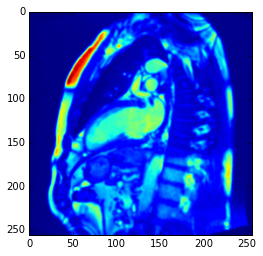

In [17]:
new = ndimage.gaussian_filter(two_chamber[0].pixel_array, 1)
plt.imshow(new)

In [20]:
ndimage.measurements.center_of_mass(new)

(137.28665644488325, 126.98817326788374)

In [41]:
ndimage.measurements.center_of_mass(new*mask)

(134.83826878534074, 120.35880537116431)

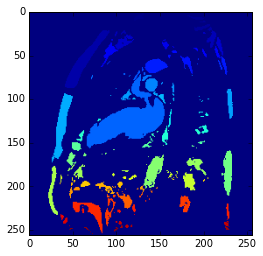

In [78]:
case = 1
two_chamber = all_times(dirs1[case])   # 2 Chamber View at t =0
im = two_chamber[0].pixel_array
mask = im > np.percentile(im, 85)
#smooth = ndimage.gaussian_filter(new*mask, 0.5)
#mask = smooth > np.percentile(smooth, 80)
#smooth = ndimage.gaussian_filter(new*mask, 0.5)
#mask = smooth > np.percentile(smooth, 90)
plt.imshow(ndimage.label(im*mask)[0])

In [132]:
line_grad_search(x,y, m1, two_chamber[0].pixel_array)

1
2
3
4


(4, 1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


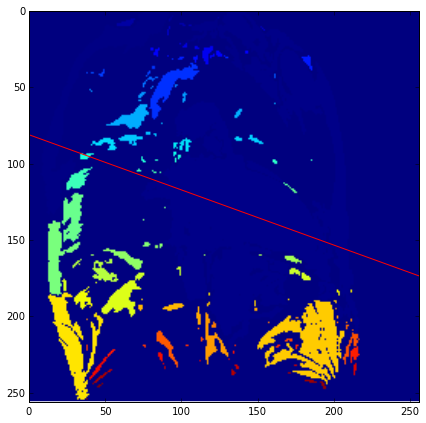

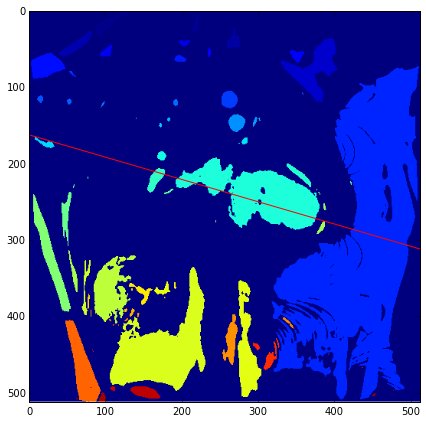

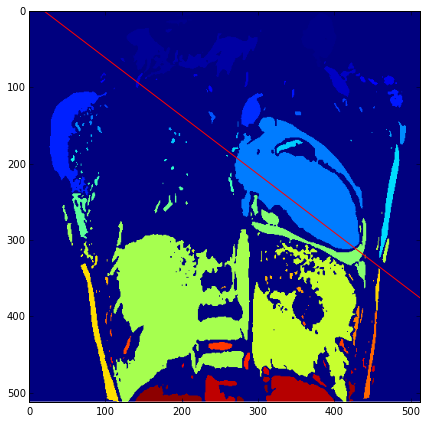

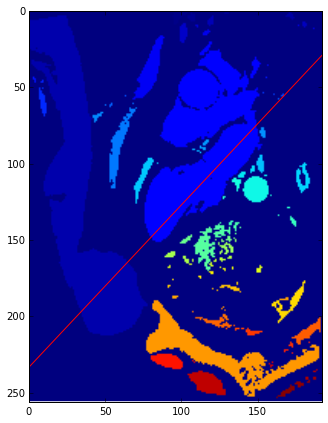

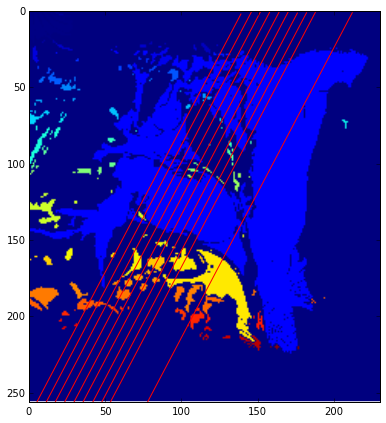

In [102]:
broken = []
for case in range(1,101):
    try:
        ############## 2 chamber plane ###############################################################
        two_chamber = all_times(dirs1[case])   # 2 Chamber View at t =0
        normal_2ch, d2, px_space, dir1, dir2, point_2ch = get_plane_equation(two_chamber[0])
        ############### 4 chamber plane ##############################################################
        four_chamber = all_times(dirs2[case])  # 4 Chamber View at t=0
        normal_4ch, d4, _,_,_,_ = get_plane_equation(four_chamber[0])
        ##############################################################################################
        # Get intersection in (x,y,z) coordinates
        intersection = intersect_planes(normal_4ch, normal_2ch, d4, d2)
        p1 = (intersection(-100000).T - point_2ch).T
        p2 = (intersection(100000).T - point_2ch).T
        two_points = np.concatenate((p1, p2), 1)
        # Transform intersection to 2 Chamber pixel coordinates
        lax_xyz_to_pix = np.array(([dir2/px_space[0], dir1/px_space[1]]))
        line_pixels = np.matmul(lax_xyz_to_pix, two_points).astype(int)
        m, c, xmin, xmax = get_line_from_points(line_pixels, two_chamber[0].pixel_array.shape)
        xs = np.linspace(xmin, xmax)
        ys = map(lambda x: m*x + c, xs)
        fig = plt.figure(figsize=(7,7))
        im = two_chamber[0].pixel_array
        im = ndimage.gaussian_filter(im, .3)
        im = im*(im > np.percentile(im, 70))
        plt.imshow(ndimage.label(im)[0])
        plt.xlim(0, im.shape[1])
        plt.ylim(im.shape[0], 0)
        plt.plot(xs, ys, 'r')
        ##############################################################################################
        patient, sax_metas = all_slices(case)
        for i,sli in enumerate(patient):
            normal, d, _,_,_,_ = get_plane_equation(sli[0])
            # Get intersection in (x,y,z) coordinates
            intersection = intersect_planes(normal, normal_2ch, d, d2)
            p1 = (intersection(-100000).T - point_2ch).T
            p2 = (intersection(100000).T - point_2ch).T
            two_points = np.concatenate((p1, p2), 1)
            # Transform intersection to 2 Chamber pixel coordinates
            lax_xyz_to_pix = np.array(([dir2/px_space[0], dir1/px_space[1]]))
            line_pixels = np.matmul(lax_xyz_to_pix, two_points).astype(int)
            m1, c1, xmin, xmax = get_line_from_points(line_pixels, two_chamber[0].pixel_array.shape)
            x,y = intersect_lines(m1,m,c1,c)
            plt.scatter([x],[y], c='b')
            xs = np.linspace(xmin, xmax)
            ys = map(lambda x: m1*x + c1, xs)
            plt.plot(xs, ys, 'r')
        plt.savefig(str(case))
        plt.close(fig)
    except:
        broken.append(case)

In [38]:
case = 1
two_chamber = all_times(dirs1[case])   # 2 Chamber View
two_ch = get_meta(two_chamber[0]) #Get at t=0
two_ch_pic = two_chamber[0].pixel_array
dir1 = two_ch['ImageOrientationPatient'][:3]
dir2 = two_ch['ImageOrientationPatient'][3:]
sp_y, sp_x = two_ch['PixelSpacing']
np.array([dir2/sp_y, dir1/sp_x])

array([[ -1.25442366e-01,  -5.49960064e-10,  -6.27586020e-01],
       [ -3.78699873e-01,   5.10349587e-01,   7.56948154e-02]])

### Get equation of line in pixels

In [88]:
def get_line_from_points(line_pixels):
    '''Gets equation of line and x_bounds to draw line. line_pixels is a 2x2 matrix where each column is a point
        on the line'''
    dy = line_pixels[0][0] - line_pixels[0][1]
    dx = line_pixels[1][0] - line_pixels[1][1]
    m = float(dy)/dx
    c = line_pixels[0][0] - m*line_pixels[1][0]

    x_left = max(0,-1*c/m)
    x_right = min(tmask.shape[1], (tmask.shape[0]-c)/m)

    if c < 0:
        if m > 0:
            x_left = max(0,-1*c/m)
            x_right = min(tmask.shape[1], (tmask.shape[0]-c)/m)
        else:
            print 'No Line'
            x_right = min(tmask.shape[1],-1*c/m)
            x_left = max(0, (tmask.shape[0]-c)/m)
    else:
        if m > 0:
            x_left = max(0,-1*c/m)
            x_right = min(tmask.shape[1], (tmask.shape[0]-c)/m)
        else:
            x_right = max(0,-1*c/m)
            x_left = min(tmask.shape[1], (tmask.shape[0]-c)/m)
        
    return m, c, int(x_left), int(x_right)

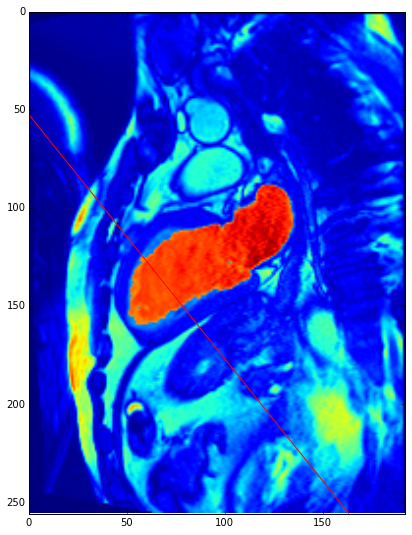

In [90]:
case = 5
two_chamber = all_times(dirs1[case])   # 2 Chamber View
two_ch = get_meta(two_chamber[0]) #Get at t=0
two_ch_pic = two_chamber[0].pixel_array
#four_chamber = all_times(dirs2[case])[0]  # 4 Chamber View at t=0
#four_ch = get_meta(four_chamber)
#four_ch_pic = four_chamber.pixel_array
#2ch Plane
dir1 = two_ch['ImageOrientationPatient'][:3]
dir2 = two_ch['ImageOrientationPatient'][3:]
normal_2ch = np.cross(dir1, dir2)
point_2ch = two_ch['ImagePositionPatient']
b2 = normal_2ch[1]
c2 = normal_2ch[2]
d2 = np.dot(point_2ch, normal_2ch)
plt.figure(figsize=(9,9))
plt.xlim(0, two_ch_pic.shape[1])
plt.ylim(two_ch_pic.shape[0], 0)
# get centroid of stfd
stfd = spatial_temporal_finite_difference([two_chamber[i].pixel_array for i in range(30)])
stfd = threshold_std(stfd)
result = ndimage.gaussian_filter(stfd, 1.)
row,col = get_centroid(result)
# get connected component corresponding to centroid
tmask, num_comps = ndimage.label(two_ch_pic > np.percentile(two_ch_pic, q=75))
#fig = plt.figure(figsize=(8,8))
plt.imshow(200*(tmask == tmask[row,col])+two_ch_pic)
plt.xlim(0,tmask.shape[1])
plt.ylim(tmask.shape[0],0)
# Short axis view of a particular slice at t=0
patient, sax_metas = all_slices(case)
##############################
i = 4
sli = patient[i]
##############################
sax = sli[0].pixel_array   
sax_meta = sax_metas[i]
#SAX Plane
sdir1 = sax_meta['ImageOrientationPatient'][:3]
sdir2 = sax_meta['ImageOrientationPatient'][3:]
normal_sax = np.cross(sdir1, sdir2)
point_sax = sax_meta['ImagePositionPatient']
b1 = normal_sax[1]
c1 = normal_sax[2]
d1 = np.dot(point_sax, normal_sax)
# Get intersection in (x,y,z) coordinates
intersection = intersect_planes(normal_sax, normal_2ch, b1, b2, c1, c2, d1, d2)
p1 = (intersection(-1000).T - point_2ch).T
p2 = (intersection(1000).T - point_2ch).T
two_points = np.concatenate((p1, p2), 1)
# Transform intersection to 2 Chamber pixel coordinates
sp_y, sp_x = two_ch['PixelSpacing']
lax_xyz_to_pix = np.array(([dir2/sp_y, dir1/sp_x]))
line_pixels = np.matmul(lax_xyz_to_pix, two_points).astype(int)
# Plot that shit
m, c, xmin, xmax = get_line_from_points(line_pixels)
xs = np.linspace(xmin, xmax)
ys = map(lambda x: m*x + c, xs)
plt.plot(xs, ys, 'r')

In [69]:
dy = line_pixels[0][0] - line_pixels[0][1]
dx = line_pixels[1][0] - line_pixels[1][1]
m = float(dy)/dx
c = line_pixels[0][0] - m*line_pixels[1][0]
m, c

x_left = max(0,-1*c/m)
x_right = min(tmask.shape[1], (tmask.shape[0]-c)/m)

if c < 0:
    if m > 0:
        x_left = max(0,-1*c/m)
        x_right = min(tmask.shape[1], (tmask.shape[0]-c)/m)
    else:
        print 'No Line'
        x_right = min(tmask.shape[1],-1*c/m)
        x_left = max(0, (tmask.shape[0]-c)/m)
else:
    if m > 0:
        x_left = max(0,-1*c/m)
        x_right = min(tmask.shape[1], (tmask.shape[0]-c)/m)
    else:
        x_right = max(0,-1*c/m)
        x_left = min(tmask.shape[1], (tmask.shape[0]-c)/m)
        
m,c, int(x_left), int(x_right)

(1.2466216216216217, 52.462837837837469, 0, 163)

In [284]:
stfd = spatial_temporal_finite_difference([all_times(dirs1[case])[i].pixel_array for i in range(30)])

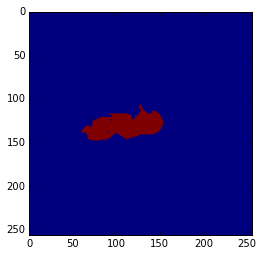

In [296]:
# get centroid of stfd
stfd = threshold_std(stfd)
result = ndimage.gaussian_filter(stfd, GAUSSIAN_BLUR_PRE_CENTROID_STFD)
row,col = get_centroid(result)
# get connected component corresponding to centroid
new_im = two_ch_pic > np.percentile(two_ch_pic, q=80)
tmask, num_comps = ndimage.label(new_im)
plt.imshow(tmask == tmask[row,col])

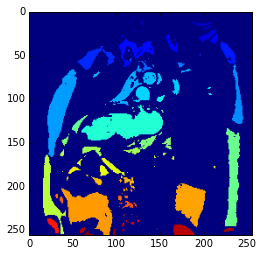

In [288]:
im = two_ch_pic#[rstart:rend, cstart:cend] 
new_im = im > np.percentile(im, q=80)
tmask, num_comps = ndimage.label(new_im)
plt.imshow(tmask)

In [ ]:
case = 12
two_chamber = all_times(dirs1[case])[0]   # 2 Chamber View at t=0
two_ch = get_meta(two_chamber)
two_ch_pic = two_chamber.pixel_array

stfd = spatial_temporal_finite_difference(two_chamber)

### Get the intersection between the SAX slice and the 2 Chamber Slice

#### The normal is (a, b, c)

If a is not 0 a point on the plane is (-d/a, 0, 0)
If b is not 0 a point on the plane is (0, -d/b, 0)
If c is not 0 a point on the plane is (0, 0, -d/c)

In [2]:
from mpl_toolkits.mplot3d import Axes3D

point1  = np.array([0,0,0])
normal1 = np.array([1,-2,1])

In [4]:
# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d1 = -np.sum(point1*normal1)# dot product

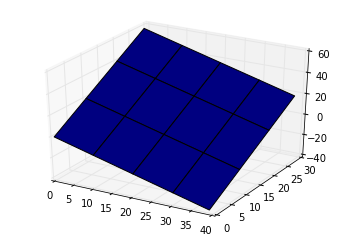

In [6]:
# create x,y
xx, yy = np.meshgrid(range(40), range(30))

# calculate corresponding z
z1 = (-normal1[0]*xx - normal1[1]*yy - d1)*1./normal1[2]
# plot the surface
plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(xx,yy,z1, color='blue')

### Loading a patient DICOM

In [3]:
dirs1 = [] #2ch
dirs2 = [] #4ch
for case in range(1,501):
    datadir = os.path.join(root_train, '%d/study/' % case)
    #chamber = os.path.join(datadir)
    dirs1 += glob(os.path.join(datadir, '2ch_*'))
    dirs2 += glob(os.path.join(datadir, '4ch_*'))
    
a = all_times(dirs1[3])

In [9]:
plt.imshow(four_ch_pic)
plt.show()

In [11]:
pics, meta = all_slices(4)

In [20]:
dir1 = meta[0]['ImageOrientationPatient'][:3]
dir2 = meta[0]['ImageOrientationPatient'][3:]
normal1 = np.cross(dir1, dir2)

print np.dot(dir1, dir2), np.dot(dir1, normal1), np.dot(dir2, normal1)

-2.50632847809e-14 -9.71445146547e-17 0.0


In [95]:
pics[0][0].pixel_array.shape

(256, 192)

In [21]:
#First Slice
dir1 = meta[0]['ImageOrientationPatient'][:3]
dir2 = meta[0]['ImageOrientationPatient'][3:]
normal1 = np.cross(dir1, dir2)
point1 = meta[0]['ImagePositionPatient']
d1 = -np.sum(point1*normal1)# dot product
# create x,y
rows, cols = pics[0][0].pixel_array.shape
xx, yy = np.meshgrid(range(int(point1[0]), int(point1[0]) + cols), range(int(point1[1]), int(point1[1]) + rows))
# calculate corresponding z
z1 = (-normal1[0]*xx - normal1[1]*yy - d1)*1./normal1[2]

# Last slice
dir1 = meta[-1]['ImageOrientationPatient'][:3]
dir2 = meta[-1]['ImageOrientationPatient'][3:]
normal2 = np.cross(dir1, dir2)
point2 = meta[-1]['ImagePositionPatient']
d2 = -np.sum(point2*normal2)# dot product
# calculate corresponding z
z2 = (-normal2[0]*xx - normal2[1]*yy - d2)*1./normal2[2]

# Long Axis - 2 Chamber
dir1 = two_ch['ImageOrientationPatient'][:3]
dir2 = two_ch['ImageOrientationPatient'][3:]
normal3 = np.cross(dir1, dir2)
point3 = two_ch['ImagePositionPatient']
d3 = -np.sum(point3*normal3)# dot product
# calculate corresponding z
z3 = (-normal3[0]*xx - normal3[1]*yy - d3)*1./normal3[2]

# Long Axis - 4 Chamber
dir1 = four_ch['ImageOrientationPatient'][:3]
dir2 = four_ch['ImageOrientationPatient'][3:]
normal4 = np.cross(dir1, dir2)
point4 = four_ch['ImagePositionPatient']
d4 = -np.sum(point4*normal4)# dot product
# calculate corresponding z
z4 = (-normal4[0]*xx - normal4[1]*yy - d4)*1./normal4[2]

# plot the surface
plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(xx,yy,z1, color='blue')
plt3d.plot_surface(xx,yy,z2, color='blue')
plt3d.plot_surface(xx,yy,z3, color='green')
plt3d.plot_surface(xx,yy,z4, color='red')
plt.show()

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [71]:
diff = np.abs(z3 - z2)
diff /= diff.max()

plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(xx,yy,(diff < 0.01), color='blue')
plt.show()

In [72]:
plt.imshow(diff < 0.008)
diff2 = np.abs(z4 - z2)
diff2 /= diff2.max()
plt.imshow(diff2 < 0.008)
plt.show()

In [13]:
def plot_sax_slices(meta):
    # plot the surface
    plt3d = plt.figure().gca(projection='3d')
    # create x,y
    xx, yy = np.meshgrid(range(10), range(7))
    for m in meta:
        dir1 = m['ImageOrientationPatient'][:3]
        dir2 = m['ImageOrientationPatient'][3:]
        normal = np.cross(dir1, dir2)
        point = m['ImagePositionPatient']
        d = -np.sum(point*normal)# dot product
        # calculate corresponding z
        z = (-normal[0]*xx - normal[1]*yy - d)*1./normal[2]
        plt3d.plot_surface(xx,yy,z)
    plt.show()

In [14]:
plot_sax_slices(meta)

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [79]:
normal3

array([-0.7249391 , -0.64934772, -0.22980609])

In [81]:
f1 = intersect_planes(normal1, d1, normal3, d3)
y1 = np.array([f1(x) for x in range(100)])

f2 = intersect_planes(normal1, d1, normal4, d4)
y2 = np.array([f2(x) for x in range(100)])

plt.plot(np.array(range(100)), y1)
plt.plot(np.array(range(100)), y2)
plt.show()

## Slice Coordinates to Global Coordinate Frame

In [215]:
## Short axis plane
dir1 = meta[0]['ImageOrientationPatient'][:3]
dir2 = meta[0]['ImageOrientationPatient'][3:]
normal1 = np.cross(dir1, dir2)
point1 = meta[0]['ImagePositionPatient']
d1 = np.dot(point1,normal1)
b1 = normal1[1]
c1 = normal1[2]
## 4 chamber plane
dir1 = four_ch['ImageOrientationPatient'][:3]
dir2 = four_ch['ImageOrientationPatient'][3:]
normal4 = np.cross(dir1, dir2)
point4 = four_ch['ImagePositionPatient']
b4 = normal4[1]
c4 = normal4[2]
d4 = np.dot(point4,normal4)
# Get intersection in (x,y,z) coordinates
intersection = intersect_planes(normal1, normal4, b1, b4, c1, c4, d1, d4)
points = np.array([intersection(t) for t in range(0,300)])
points = points.reshape((300,3))
# Transform intersection to 4chamber pixel coordinates
pixel_sp = np.sqrt(four_ch['PixelSpacing'])
lax_xyz_to_pix = (np.array(([dir1, dir2]))/pixel_sp).T
line_pixels = np.matmul(points,lax_xyz_to_pix).astype(int)

In [213]:
plt.plot(line_pixels[:,0], line_pixels[:,1])
plt.show()

In [216]:
#plt.plot(line_pixels[:,0],line_pixels[:,1])
mod_pic = four_ch_pic.copy()
for pix in line_pixels:
    mod_pic[pix[0], pix[1]] += 500

plt.imshow(mod_pic)
plt.show()

In [22]:
def get_coord_matrix(dir1, dir2, imgPos, pixelSpacing):
    '''Returns a matrix that transforms a dicom array index to a location in the patient'''
    M = np.zeros((4,4))
    M[:3, 1] = pixelSpacing[0]*dir1.T
    M[:3, 0] = pixelSpacing[1]*dir2.T #Swapped them to deal with dicom row-col order
    M[:3, 3] = imgPos.T
    M[3,3] = 1
    
    return M

In [104]:
np.shape(pics[0][0].pixel_array)

(256, 192)

In [120]:
## Short axis plane
dir1 = meta[0]['ImageOrientationPatient'][:3]
dir2 = meta[0]['ImageOrientationPatient'][3:]
normal1 = np.cross(dir1, dir2)
point1 = meta[0]['ImagePositionPatient']
d1 = -np.dot(point1,normal1)

pixel_sp = np.sqrt(meta[0]['PixelSpacing'])
sax_pix_to_xyz = np.array(pixel_sp*[dir1, dir2]).T

xcoords = []
for i in range(256):
    for j in range(192):
        pixel = np.array([i,j]).T
        x,y,z = (np.matmul(sax_pix_to_xyz, pixel) + point1).astype(int)
        coords.append(x)

coords = set(coords)
#coords = list(coords)
#M1 = get_coord_matrix(dir1, dir2, point1, (pixel_sp, pixel_sp))
## 4 chamber plane
dir1 = four_ch['ImageOrientationPatient'][:3]
dir2 = four_ch['ImageOrientationPatient'][3:]
normal4 = np.cross(dir1, dir2)
point4 = four_ch['ImagePositionPatient']
d4 = -np.dot(point4,normal4)

intersection = intersect_planes(normal1, d1, normal4, d4)
#pixel_sp = np.sqrt(four_ch['PixelSpacing'])

#
#lax_xyz_to_pix = np.array([dir1, dir2])
#new_pixel = np.matmul(lax_xyz_to_pix, coord)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [123]:
max(coords) - min(coords)

213

In [135]:
xs = np.array(range(min(coords), max(coords) + 1))
ys = intersection(xs)

#Change ys to voxels instead of absolute locations
dir1 = four_ch['ImageOrientationPatient'][:3]
dir2 = four_ch['ImageOrientationPatient'][3:]
xyz_to_lax_pix = np.array(pixel_sp*[dir1[:2], dir2[:2]])

#plt.plot(xs, ys)
#plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [149]:
points = np.zeros((len(xs),2))
points[:,0] = xs
points[:,1] = ys

new_points = np.matmul(points, xyz_to_lax_pix).astype(int)

In [150]:
plt.plot(new_points[:,0], new_points[:,1])
plt.show()

In [28]:
M2 = get_coord_matrix(dir1, dir2, point1, (pixel_sp, pixel_sp))

In [33]:
M3 = np.matmul(np.linalg.pinv(M2), M1)

In [36]:
p = np.array([point1[0],point1[1], 0, 1])
np.matmul(M3,p)

array([ 4808.16844502,  1902.52465319,     0.        ,    35.30246743])

In [40]:
m5 = np.array([dir1, dir2])
m5
# In this case, the pseudoinverse = m5.transpose

array([[  4.61539531e-01,   8.45090654e-01,  -2.69820399e-01],
       [ -5.04692627e-01,  -1.32756074e-07,  -8.63299109e-01]])

In [54]:
pixel = np.array([0,0]).T #Try to map the top left from SAX to 4ch

dir1 = meta[0]['ImageOrientationPatient'][:3]
dir2 = meta[0]['ImageOrientationPatient'][3:]
point1 = meta[0]['ImagePositionPatient']

sax_pix_to_xyz = np.array([dir1, dir2]).T

coord = np.matmul(sax_pix_to_xyz, pixel) + point1
#
dir1 = four_ch['ImageOrientationPatient'][:3]
dir2 = four_ch['ImageOrientationPatient'][3:]
point4 = four_ch['ImagePositionPatient']
lax_xyz_to_pix = np.array([dir1, dir2])

new_pixel = np.matmul(lax_xyz_to_pix, coord)

In [55]:
points = []
for i in range(256):
    for j in range(192):
        pixel = np.array([i,j]).T
        coord = np.matmul(sax_pix_to_xyz, pixel) + point1
        new_pixel = np.matmul(lax_xyz_to_pix, coord)
        points.append(new_pixel)

In [88]:
npoints = set(map(tuple, np.array(points).astype(int)))

In [90]:
proj = set(map(tuple, np.array(points).astype(int)))
#proj = np.array(set(points))
mod_pic = four_ch_pic.copy()
for pixel in proj:
    mod_pic[pixel[0], pixel[1]] += 500

In [92]:
mod_pic.max()

994

In [93]:
plt.imshow(mod_pic)
plt.show()

In [ ]:
plt.imshow(four_ch_pic)
plt.show()

### +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [130]:
im = pics[0][0].pixel_array

In [140]:
locs = np.zeros((im.shape[0],im.shape[1],3))
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        locs[i*imshape[1] j] = np.matmul(M, np.array([i,j,0,1]))[:3]

In [136]:
np.matmul(M, np.array((1,2,0,1)))

array([-131.85602385, -126.12107769,  -89.12769861,    1.        ])

In [144]:
locs.shape

(256, 192, 3)

In [145]:
new_locs = locs.reshape((256*192, 3))

In [146]:
new_locs.shape

(49152, 3)

In [149]:
plt3d = plt.figure().gca(projection='3d')
plt3d.scatter(xvals, yvals, zvals)
plt.show()